In [1]:
# 모듈 수정 시 따로 커널 재시작 안해도 바로 적용해주는 extension.
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 0
%env DETECTRON2_DATASETS ./data/
%cd /surrogate_v2/

env: CUDA_VISIBLE_DEVICES=0
env: DETECTRON2_DATASETS=./data/
/surrogate_v2


In [48]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
import models
import codec_ops
import checkpoint

## Image Visualization

In [50]:
task = 'detection'
od_network_name = 'faster_rcnn_X_101_32x8d_FPN_3x'
saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q1_ld1.0')
step = 50000

od_cfg = utils.get_od_cfg(task, od_network_name)
end2end = models.EndToEndNetwork(1, task, od_cfg)
ckpt = checkpoint.Checkpoint(saved_filter_model_path)
ckpt.load(end2end.filtering_network, step=step)

end2end.eval()
end2end.cuda();

In [29]:
sample_img_path = 'data/open-images-v6-etri/validation/0b30ad1afeba9bca.jpg'
img_arr = cv2.imread(sample_img_path)

codec = 'vvenc'
codec_quality = 47
downscale = 0

out = end2end(img_arr, codec, codec_quality, downscale, eval_filtering=True)

In [45]:
images = [
    {
        'original': img_arr[:, :, ::-1],
        'original_recon': codec_ops.codec_fn(
            img_arr[:, :, ::-1].transpose(2, 0, 1) / 255.,
            codec, codec_quality, downscale)[0].transpose(1, 2, 0)
    },
    {
        'filtered': out['image']['filtered'],
        'filtered_recon': out['image']['reconstructed'],
    }
]

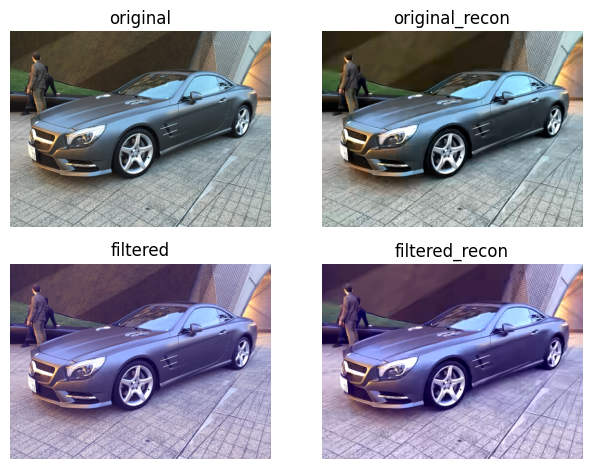

In [47]:
fig, axes = plt.subplots(2, 2)

for imgs, row_axes in zip(images, axes):
    for (name, img), ax in zip(imgs.items(), row_axes):
        ax.axis(False)
        ax.set_title(name)
        ax.imshow(img)

plt.tight_layout()
plt.show()
fig.savefig('sample_output.png', dpi=500)

## Result Plotting

In [ ]:
pd.read_csv(saved_filter_model_path / 'result.csv')